# Customer Churn Prediction & Analysis

**Objectives:** Predict churn, explain why, estimate CLV, segment customers, prioritize interventions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except: XGBOOST_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
except: SHAP_AVAILABLE = False

plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries loaded")

Libraries loaded


## 1. Data Loading & Preprocessing

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"Dataset: {df.shape[0]} customers, {df.shape[1]} features")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(df['MonthlyCharges'])
df['Churn_Binary'] = (df['Churn'] == 'Yes').astype(int)
print(f"Churn Rate: {df['Churn_Binary'].mean()*100:.1f}%")
df.head()

Dataset: 7043 customers, 21 features
Churn Rate: 26.5%


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Binary
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1


## 2. Exploratory Data Analysis

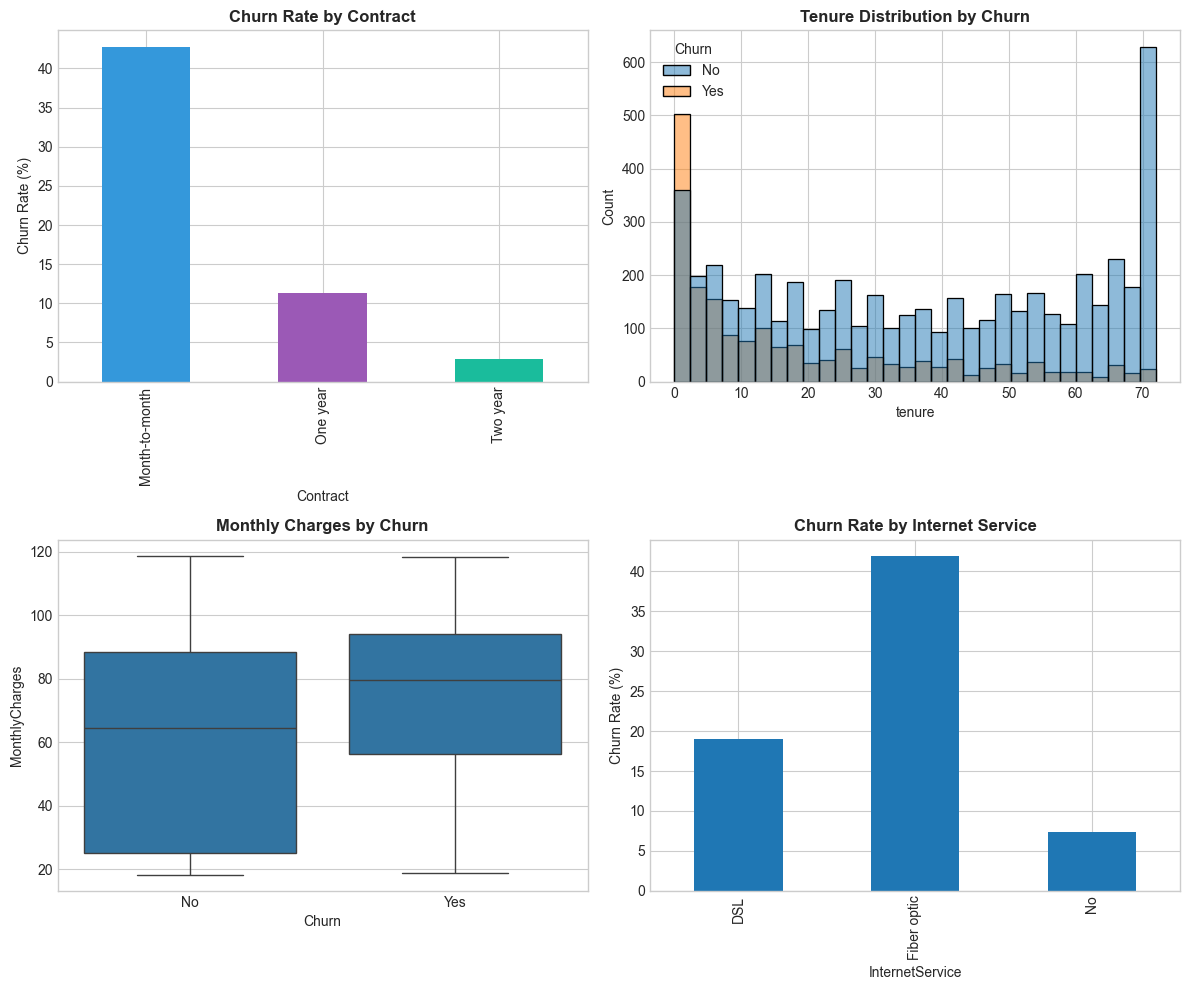

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
df.groupby('Contract')['Churn_Binary'].mean().mul(100).plot(kind='bar', ax=axes[0,0], color=['#3498db', '#9b59b6', '#1abc9c'])
axes[0,0].set_title('Churn Rate by Contract', fontweight='bold')
axes[0,0].set_ylabel('Churn Rate (%)')
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, ax=axes[0,1])
axes[0,1].set_title('Tenure Distribution by Churn', fontweight='bold')
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', ax=axes[1,0])
axes[1,0].set_title('Monthly Charges by Churn', fontweight='bold')
df.groupby('InternetService')['Churn_Binary'].mean().mul(100).plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Churn Rate by Internet Service', fontweight='bold')
axes[1,1].set_ylabel('Churn Rate (%)')
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [4]:
df_model = df.copy()
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_model['TotalServices'] = df_model[service_cols].apply(
    lambda x: sum(v not in ['No', 'No phone service', 'No internet service'] for v in x), axis=1)
df_model['ContractRisk'] = df_model['Contract'].map({'Month-to-month': 3, 'One year': 2, 'Two year': 1})
df_model['HighSpender'] = (df_model['MonthlyCharges'] > df_model['MonthlyCharges'].median()).astype(int)
df_model['AvgSpendPerService'] = df_model['MonthlyCharges'] / (df_model['TotalServices'] + 1)
print("Features created: TotalServices, ContractRisk, HighSpender, AvgSpendPerService")

Features created: TotalServices, ContractRisk, HighSpender, AvgSpendPerService


In [5]:
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod']
df_encoded = df_model.copy()
for col in cat_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

feature_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
                'TotalServices', 'AvgSpendPerService', 'ContractRisk', 'HighSpender'] + cat_cols
X = df_encoded[feature_cols]
y = df_encoded['Churn_Binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
class_weight_ratio = (len(y_train) - y_train.sum()) / y_train.sum()
print(f"Train: {len(y_train)}, Test: {len(y_test)}, Class Weight: {class_weight_ratio:.2f}")

Train: 5634, Test: 1409, Class Weight: 2.77


## 4. Model Training with Cross-Validation

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_cv = cross_val_score(lr, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
lr.fit(X_train_scaled, y_train)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
results['Logistic Regression'] = {'CV_AUC': lr_cv.mean(), 'Test_AUC': roc_auc_score(y_test, y_prob_lr)}

rf = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
rf_cv = cross_val_score(rf, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
rf.fit(X_train_scaled, y_train)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]
results['Random Forest'] = {'CV_AUC': rf_cv.mean(), 'Test_AUC': roc_auc_score(y_test, y_prob_rf)}

if XGBOOST_AVAILABLE:
    xgb = XGBClassifier(n_estimators=100, max_depth=5, scale_pos_weight=class_weight_ratio, 
                        random_state=42, eval_metric='logloss')
    xgb_cv = cross_val_score(xgb, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    xgb.fit(X_train_scaled, y_train)
    y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]
    results['XGBoost'] = {'CV_AUC': xgb_cv.mean(), 'Test_AUC': roc_auc_score(y_test, y_prob_xgb)}
else:
    y_prob_xgb = y_prob_rf

print("Model Comparison:")
print(pd.DataFrame(results).T.round(3))

Model Comparison:
                     CV_AUC  Test_AUC
Logistic Regression   0.844     0.839
Random Forest         0.844     0.836
XGBoost               0.823     0.825


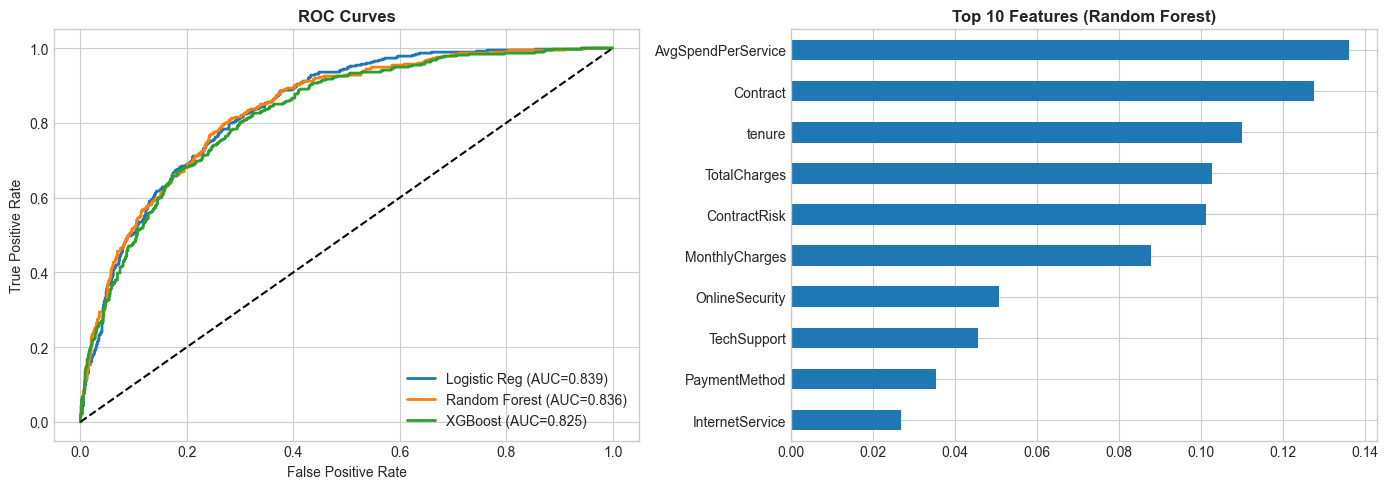

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name, prob in [('Logistic Reg', y_prob_lr), ('Random Forest', y_prob_rf)]:
    fpr, tpr, _ = roc_curve(y_test, prob)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, prob):.3f})', linewidth=2)
if XGBOOST_AVAILABLE:
    fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
    axes[0].plot(fpr, tpr, label=f'XGBoost (AUC={roc_auc_score(y_test, y_prob_xgb):.3f})', linewidth=2)
axes[0].plot([0,1], [0,1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves', fontweight='bold')
axes[0].legend()

pd.Series(rf.feature_importances_, index=feature_cols).sort_values().tail(10).plot(kind='barh', ax=axes[1])
axes[1].set_title('Top 10 Features (Random Forest)', fontweight='bold')
plt.tight_layout()
plt.show()

## 5. SHAP Analysis - Model Interpretability

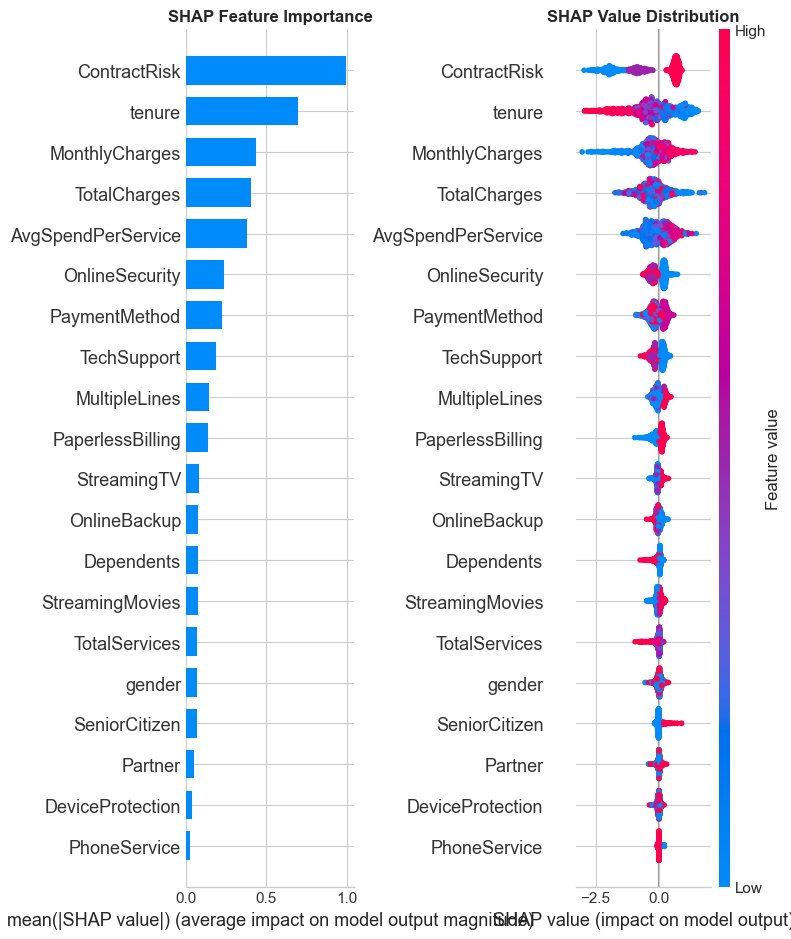

Red = High value, Blue = Low | Right = Increases churn, Left = Decreases churn


In [8]:
if SHAP_AVAILABLE and XGBOOST_AVAILABLE:
    explainer = shap.TreeExplainer(xgb)
    X_test_df = pd.DataFrame(X_test_scaled, columns=feature_cols)
    shap_values = explainer.shap_values(X_test_df)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plt.sca(axes[0])
    shap.summary_plot(shap_values, X_test_df, plot_type='bar', show=False)
    plt.title('SHAP Feature Importance', fontweight='bold')
    plt.sca(axes[1])
    shap.summary_plot(shap_values, X_test_df, show=False)
    plt.title('SHAP Value Distribution', fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("Red = High value, Blue = Low | Right = Increases churn, Left = Decreases churn")
else:
    print("SHAP or XGBoost not available. Install with: pip install shap xgboost")

## 6. Customer Lifetime Value (CLV)

In [9]:
X_all_scaled = scaler.transform(df_encoded[feature_cols])
best_model = xgb if XGBOOST_AVAILABLE else rf
df_model['ChurnProb'] = best_model.predict_proba(X_all_scaled)[:, 1]

margin_rate = 0.30
monthly_discount = 0.10 / 12
df_model['Margin'] = df_model['MonthlyCharges'] * margin_rate
df_model['RetentionRate'] = 1 - df_model['ChurnProb']
df_model['CLV'] = df_model['Margin'] * (df_model['RetentionRate'] / 
                                         np.maximum(1 + monthly_discount - df_model['RetentionRate'], 0.01))
df_model['CLV'] = df_model['CLV'].clip(upper=df_model['CLV'].quantile(0.99))

print(f"CLV Statistics:")
print(f"  Mean: ${df_model['CLV'].mean():.0f}")
print(f"  Median: ${df_model['CLV'].median():.0f}")
print(f"  Max: ${df_model['CLV'].max():.0f}")

CLV Statistics:
  Mean: $297
  Median: $55
  Max: $2672


## 7. RFM Scoring

In [10]:
df_model['R_Score'] = pd.qcut(df_model['tenure'], 5, labels=[1,2,3,4,5], duplicates='drop').astype(int)
df_model['F_Score'] = pd.qcut(df_model['TotalServices'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
df_model['M_Score'] = pd.qcut(df_model['MonthlyCharges'], 5, labels=[1,2,3,4,5]).astype(int)
df_model['RFM_Score'] = df_model['R_Score'] + df_model['F_Score'] + df_model['M_Score']
print("RFM Score Distribution:")
print(df_model['RFM_Score'].value_counts().sort_index())

RFM Score Distribution:
RFM_Score
3     362
4     354
5     601
6     741
7     677
8     664
9     581
10    561
11    557
12    481
13    497
14    530
15    437
Name: count, dtype: int64


## 8. Customer Segmentation

In [11]:
clv_med = df_model['CLV'].median()
churn_thresh = 0.5

def segment(row):
    high_clv = row['CLV'] >= clv_med
    high_risk = row['ChurnProb'] >= churn_thresh
    if high_clv and not high_risk: return 'Champions'
    if high_clv and high_risk: return 'At-Risk Stars'
    if not high_clv and not high_risk: return 'Stable'
    return 'Low Priority'

df_model['Segment'] = df_model.apply(segment, axis=1)

df_model['InterventionScore'] = (df_model['ChurnProb'] * 
                                  (df_model['CLV'] / df_model['CLV'].max()) * 
                                  (df_model['ContractRisk'] / 3))
df_model['InterventionScore'] = ((df_model['InterventionScore'] - df_model['InterventionScore'].min()) / 
                                  (df_model['InterventionScore'].max() - df_model['InterventionScore'].min()) * 100)

print("Customer Segments:")
print(df_model['Segment'].value_counts())

Customer Segments:
Segment
Champions       3522
Low Priority    2540
Stable           981
Name: count, dtype: int64


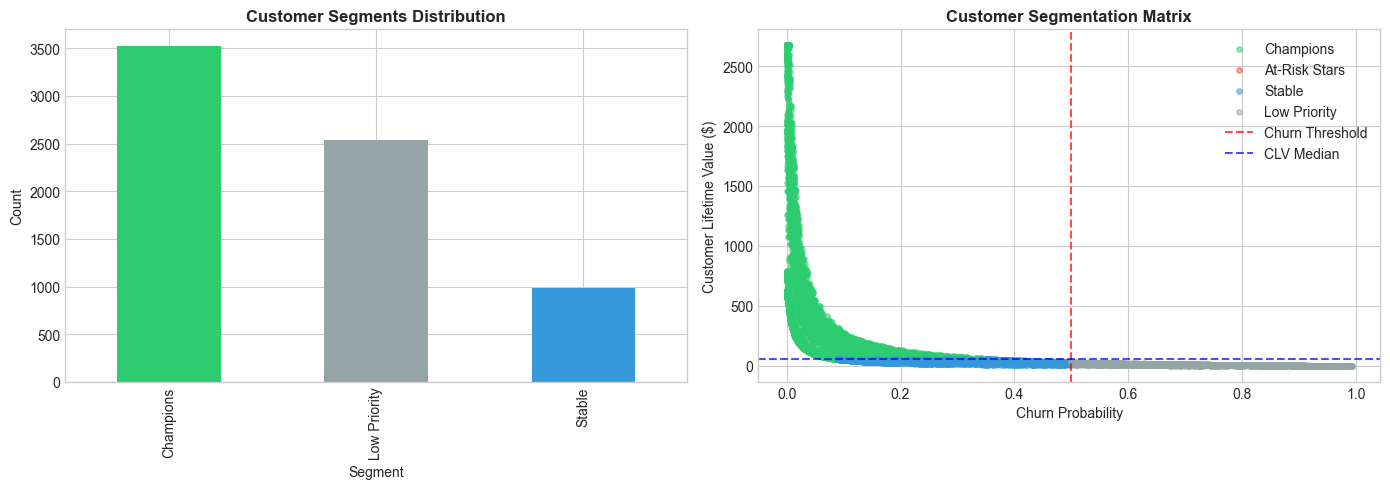

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {'Champions': '#2ecc71', 'At-Risk Stars': '#e74c3c', 'Stable': '#3498db', 'Low Priority': '#95a5a6'}

segment_counts = df_model['Segment'].value_counts()
segment_counts.plot(kind='bar', ax=axes[0], color=[colors[x] for x in segment_counts.index])
axes[0].set_title('Customer Segments Distribution', fontweight='bold')
axes[0].set_ylabel('Count')

for seg, col in colors.items():
    mask = df_model['Segment'] == seg
    axes[1].scatter(df_model.loc[mask, 'ChurnProb'], df_model.loc[mask, 'CLV'], 
                   label=seg, alpha=0.5, c=col, s=15)
axes[1].axvline(x=churn_thresh, color='red', linestyle='--', alpha=0.7, label='Churn Threshold')
axes[1].axhline(y=clv_med, color='blue', linestyle='--', alpha=0.7, label='CLV Median')
axes[1].set_xlabel('Churn Probability')
axes[1].set_ylabel('Customer Lifetime Value ($)')
axes[1].set_title('Customer Segmentation Matrix', fontweight='bold')
axes[1].legend(loc='upper right')
plt.tight_layout()
plt.show()

## 9. Business Recommendations

In [13]:
retention = df_model[df_model['Segment'] == 'At-Risk Stars']
champions = df_model[df_model['Segment'] == 'Champions']
low_priority = df_model[df_model['Segment'] == 'Low Priority']

print("="*60)
print("BUSINESS RECOMMENDATIONS")
print("="*60)

print(f"\nRETENTION PRIORITY: {len(retention)} customers")
print(f"  Monthly Revenue at Risk: ${retention['MonthlyCharges'].sum():,.0f}")
print(f"  Annual Revenue at Risk: ${retention['MonthlyCharges'].sum() * 12:,.0f}")
print(f"  Recommended Action: Personal outreach, contract upgrades, loyalty rewards")

print(f"\nEARLY ACCESS CANDIDATES: {len(champions)} customers")
print(f"  Average Tenure: {champions['tenure'].mean():.0f} months")
print(f"  Recommended Action: VIP programs, beta access, referral incentives")

lost = low_priority[low_priority['ChurnProb'] > 0.7]
print(f"\nLIKELY TO CHURN REGARDLESS: {len(lost)} customers")
print(f"  Recommended Action: Minimal investment, exit surveys, win-back campaigns later")

BUSINESS RECOMMENDATIONS

RETENTION PRIORITY: 0 customers
  Monthly Revenue at Risk: $0
  Annual Revenue at Risk: $0
  Recommended Action: Personal outreach, contract upgrades, loyalty rewards

EARLY ACCESS CANDIDATES: 3522 customers
  Average Tenure: 47 months
  Recommended Action: VIP programs, beta access, referral incentives

LIKELY TO CHURN REGARDLESS: 1739 customers
  Recommended Action: Minimal investment, exit surveys, win-back campaigns later


In [14]:
print("\nTOP 15 INTERVENTION PRIORITIES:")
print("="*60)
top = df_model.nlargest(15, 'InterventionScore')[[
    'customerID', 'Segment', 'ChurnProb', 'CLV', 'InterventionScore', 'Contract', 'tenure'
]].copy()
top['ChurnProb'] = (top['ChurnProb'] * 100).round(1).astype(str) + '%'
top['CLV'] = '$' + top['CLV'].round(0).astype(int).astype(str)
top['InterventionScore'] = top['InterventionScore'].round(1)
print(top.to_string(index=False))


TOP 15 INTERVENTION PRIORITIES:
customerID   Segment ChurnProb  CLV  InterventionScore       Contract  tenure
8016-NCFVO Champions     16.7% $166              100.0 Month-to-month      55
2067-QYTCF Champions     11.4% $241               99.3 Month-to-month      64
2522-AHJXR Champions     10.0% $273               98.4 Month-to-month      60
9052-VKDUW Champions      6.0% $450               97.7 Month-to-month      65
3657-COGMW Champions     11.0% $243               96.8 Month-to-month      52
6067-NGCEU Champions      4.4% $611               96.6 Month-to-month      65
3761-FLYZI Champions     13.1% $204               96.2 Month-to-month      65
3331-HQDTW Champions     14.7% $180               95.9 Month-to-month      34
9481-IEBZY Champions      3.6% $742               95.5 Month-to-month      72
0363-QJVFX Champions     13.5% $196               95.4 Month-to-month      32
9971-ZWPBF Champions     14.7% $179               95.1 Month-to-month      34
2133-TSRRM Champions      8.1% 

## 10. Export Results

In [15]:
export = df_model[['customerID', 'Segment', 'ChurnProb', 'CLV', 'InterventionScore', 
                   'RFM_Score', 'Contract', 'tenure', 'MonthlyCharges']].copy()
export['ChurnProb'] = (export['ChurnProb'] * 100).round(2)
export['CLV'] = export['CLV'].round(2)
export['InterventionScore'] = export['InterventionScore'].round(2)
export = export.sort_values('InterventionScore', ascending=False)
export.to_csv('customer_segments.csv', index=False)
print(f"Exported: customer_segments.csv ({len(export)} customers)")
print(f"Location: {os.getcwd()}")

Exported: customer_segments.csv (7043 customers)
Location: C:\Users\iLaptop.pk\OneDrive\Desktop\churnanalyssi


## Key Insights Summary

In [16]:
best_auc = max(results.values(), key=lambda x: x['Test_AUC'])['Test_AUC']

print("="*60)
print("KEY INSIGHTS")
print("="*60)
print(f"""
MODEL PERFORMANCE:
  Best Model AUC: {best_auc:.3f}

TOP CHURN DRIVERS:
  1. Month-to-month contracts (42% churn rate)
  2. Short tenure (new customers are high risk)
  3. Fiber optic internet (price sensitivity)
  4. No online security service

CUSTOMER SEGMENTS:
  Champions: {len(champions)} customers - Nurture & reward
  At-Risk Stars: {len(retention)} customers - RETENTION PRIORITY
  Low Priority: {len(low_priority)} customers - Minimal investment

BUSINESS IMPACT:
  At-Risk Annual Revenue: ${retention['MonthlyCharges'].sum() * 12:,.0f}
  20% retention improvement saves: ${retention['MonthlyCharges'].sum() * 12 * 0.2:,.0f}/year

RECOMMENDED ACTIONS:
  1. Contact top intervention priority customers
  2. Offer contract upgrades to month-to-month customers
  3. Bundle OnlineSecurity + TechSupport services
""")
print("Analysis Complete!")

KEY INSIGHTS

MODEL PERFORMANCE:
  Best Model AUC: 0.839

TOP CHURN DRIVERS:
  1. Month-to-month contracts (42% churn rate)
  2. Short tenure (new customers are high risk)
  3. Fiber optic internet (price sensitivity)
  4. No online security service

CUSTOMER SEGMENTS:
  Champions: 3522 customers - Nurture & reward
  At-Risk Stars: 0 customers - RETENTION PRIORITY
  Low Priority: 2540 customers - Minimal investment

BUSINESS IMPACT:
  At-Risk Annual Revenue: $0
  20% retention improvement saves: $0/year

RECOMMENDED ACTIONS:
  1. Contact top intervention priority customers
  2. Offer contract upgrades to month-to-month customers
  3. Bundle OnlineSecurity + TechSupport services

Analysis Complete!
